# Fluxonium CZ gate tutorial

B. McDonough

This notebook provides a tutorial on using scQubits to simulate the CZ-gate on a coupled pair of fluxonium qubits described by Nesterov et al. in [Microwave-Activated Controlled-Z Gate for Fixed-Frequency Fluxonium Qubits.](https://arxiv.org/abs/1802.03095)

** NOTE: With version 5 of `qutip` the qip submodule has to be installed separately, e.g. with `pip install qutip-qip`

Capacitive coupling of two fluxonium qubits $A$ and $B$ results in the addition of the term $g \hat n_A \hat n_B$ ($\hat n$ is the charge operator) to the Hamiltonian. This coupling shifts the energy levels so that the dressed (coupled) $\omega_{01 \to 02}$ transition frequency is detuned from the dressed (coupled) $\omega_{11 \to 12}$ transition frequency. Without the capacitive coupling between two qubits, the bare (uncoupled) $\omega_{01 \to 02}$ transition frequency is the same as the bare (uncoupled) $\omega_{11 \to 12}$ transition frequency. This allows the $|11\rangle \to |12\rangle$ transition to be Rabi driven without causing leakage from other states in the computational space. Following Nesterov et al., we consider a case of selective drive on only qubit $B$, which is expressed as the term $H_d = f(t)\cos(\omega_d t)\hat n_B$ added to the Hamiltonian.

Driving the $|11\rangle\to|12\rangle$ transition for a full period of Rabi oscillation causes the $|11\rangle$ state to acquire a phase of $e^{i\pi}=-1$, without affecting the other states in the computational subspace. This results in the application of $CZ = \operatorname{diag}(1,1,1,-1)$ up to single-qubit $Z$ gates.

The Hamiltonian of the two coupled fluxonia and the drive is
$$
H = 4E_{CA}\hat n_A - E_{JA}\cos(\hat \phi_A-\pi) + \frac{1}{2} E_{LA}\hat \phi_A^2 + g\hat n_A\hat n_B + 4E_{CB}\hat n_B - E_{JB}\cos(\hat \phi_B-\pi) + \frac{1}{2}E_{LB}\hat \phi_B^2 + f(t)\cos(w_dt)\hat n_B
$$

where all of the notations follow closely the cited paper.

In [16]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
from qutip.qip.operations import rz, cz_gate
import cmath

# experimental values borrowed from
# [https://arxiv.org/abs/1802.03095]
# define fluxonium A
qbta = scq.Fluxonium(
    EC=1.5,
    EJ=5.5,
    EL=1.0,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=10,
)

# define fluxonium B
qbtb = scq.Fluxonium(
    EC=1.2,
    EJ=5.7,
    EL=1.0,
    flux=0.5,
    cutoff=110,
    truncated_dim=10,
)

# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])

# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.15,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)

# generate spectrum lookup table
hilbertspace.generate_lookup()

## Drive simulation functions

In [5]:
# get the transition frequency between two states specified by dressed indices
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )

## Truncation
The efficiency of the simulation is greatly improved by truncating the operators.  The truncation happens in two steps:
1) The first truncation is controlled by setting the `truncated_dim` parameter in the subsystem initialization, which determines the dimension used in diagonalizing the Hamiltonian. Setting these too low can result in an unphysical simulation. Even if energy levels above the truncation are not explicitly involved, they can still drastically affect the matrix elements of the operators. 

2) Once the matrix elements and eigenvalues have been obtained, the operators can be truncated further. This truncation can greatly improve the runtime of the simulation. 

In [6]:
# The matrix representations can be truncated further for the simulation
total_truncation = 20

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

## States and operators 

In [7]:
# get the representation of the n_b operator in the dressed eigenbasis of the composite system
n_b = hilbertspace.op_in_dressed_eigenbasis((qbtb.n_operator, qbtb))
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_b = truncate(n_b, total_truncation)

In [8]:
# convert the product states to the closes eigenstates of the dressed system
product_states = [(0, 0), (1, 0), (0,1), (1, 1), (2, 1)]
idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
states = [qt.basis(total_truncation, idx) for idx in idxs]

# The computational subspace is spanned by the first 4 states
computational_subspace = states[:4]

## Units
scQubits natively reports energy in GHz, units of frequency. The frequency $f$ and the radial frequency $\omega$ are related via
$$
\hbar \omega = h f
$$
The constants $h$ and $\hbar$ are related by $h = 2\pi \hbar$, so the angular frequency in units of radians per nanosecond is given by $\omega = 2\pi f$. For this reason, the energies obtained from diagonalization and the matrix elements need to be multiplied by $2\pi$ for simulating in QuTiP.

In [9]:
# get dressed state 11 to 12 transition frequency
omega_1112 = transition_frequency(idxs[3], idxs[4])

# Gaussian pulse parameters optimized by hand
A = 0.022 # GHz
tg = 100 # ns

#Gaussian pulse envelope
def drive_coeff(t: float, args: dict) -> float:
    return A * np.exp(-8 * t * (t - tg) / tg**2) * np.cos(omega_1112 * t)

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

# time-dependent drive Hamiltonian
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * n_b, drive_coeff],  # driving through the resonator
]

## Drive Visualization

Text(0.5, 0, 't (ns)')

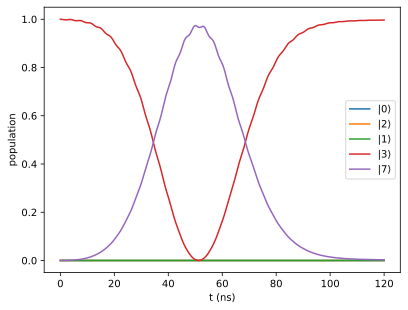

In [10]:
# array of time list
tlist = np.linspace(0, 120, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    qt.basis(20, hilbertspace.dressed_index(product_states[3])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)

for idx, res in zip(idxs, result.expect):
    plt.plot(tlist, res, label=r"$|%u\rangle$" % (idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")

## Propagator calculation

In [11]:
# get the propagator at the final time step
prop = qt.propagator(H_qbt_drive, tlist)[-1]  

# truncate the propagator to the computational subspace
Uc = qt.Qobj(
    [
        [prop.matrix_element(s1, s2) for s1 in computational_subspace]
        for s2 in computational_subspace
    ]
)

In [12]:
# Factor global phase so that upper-left corner of matrix is real
def remove_global_phase(op):
    return op * np.exp(-1j * cmath.phase(op[0, 0]))

# The process for obtaining the Z rotations is taken from page 3 of Nesterov et al., at the
# bottom of the paragraph beginning, "To model gate operation..."
def dphi(state):
    return -np.angle(prop.matrix_element(state, state)) + np.angle(
        prop.matrix_element(states[0], states[0])
    )

In [13]:
# product of single-qubit Z-gates
Uz = remove_global_phase(qt.tensor(rz(dphi(states[2])), rz(dphi(states[1]))))
Uc_reshaped = qt.Qobj(Uc.data, dims=[[2, 2], [2, 2]])
Ucprime = remove_global_phase(Uz * Uc_reshaped)
Ucprime  # result should be close to diag(1,1,1,-1)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.99994455e-01+0.00000000e+00j -7.35238808e-08+9.49722580e-08j
  -3.99462272e-05-2.18320016e-05j -8.53945610e-07+2.82838393e-08j]
 [ 7.01936751e-08+9.48654372e-08j  9.95509035e-01+5.55111512e-17j
   2.17467831e-06-6.46723817e-06j  7.57435192e-05-2.00621542e-05j]
 [ 3.99717809e-05-2.17849309e-05j -9.74653805e-07-3.01232462e-06j
   9.99609922e-01+1.66533454e-16j  3.47474459e-06+6.59966344e-07j]
 [ 2.42005956e-07+1.48874649e-07j  7.02170941e-05+3.47803599e-05j
   3.53628225e-06+4.98055978e-08j -9.77712124e-01-2.00052682e-01j]]

In [14]:
#fidelity measure given on page 3 of Nesterov et al.
((Ucprime.dag() * Ucprime).tr() + np.abs((Ucprime.dag() * cz_gate()).tr()) ** 2) / 20

0.99047765240123